# Testing methods for extracting CO2 fertilisation effect from NDVI


In [1]:
%matplotlib inline

import sys
import pickle
import warnings
import numpy as np
import xarray as xr
import pandas as pd
import seaborn as sb
import scipy.stats
import geopandas as gpd
import matplotlib.pyplot as plt
from odc.geo.xr import assign_crs
from odc.geo.geom import Geometry
from scipy.signal import detrend
from scipy.stats import theilslopes, kendalltau

from sklearn.ensemble import RandomForestRegressor
from sklearn.cross_decomposition import PLSRegression

# sys.path.append('/g/data/os22/chad_tmp/Aus_CO2_fertilisation/src')

## Analysis Parameters

In [2]:
# k = 'Alice Tableland'
# k = 'Western Mallee'
# k='Daintree-Bloomfield'
k='Warre'
# k = 'Victorian Alps'

# NDVI data
ds_path = f'/g/data/os22/chad_tmp/AusENDVI/results/publication/AusENDVI-clim_MCD43A4_gapfilled_1982_2022_0.2.0.nc'

# soil NDVI
ndvi_min_path =f'/g/data/os22/chad_tmp/Aus_CO2_fertilisation/data/ndvi_of_baresoil_5km.nc'

#ibra subregions
ecoregions_file = f'/g/data/os22/chad_tmp/Aus_phenology/data/vectors/IBRAv7_subregions_modified.geojson'

#climate data
covar_file = f'/g/data/os22/chad_tmp/Aus_CO2_fertilisation/data/covars.nc'

t1,t2 = '1982', '2022'

## Interactively plot IBRA regions

Hover over the regions to see its name

In [3]:
# gdf = gpd.read_file(ecoregions_file)
# gdf.explore(column='SUB_NAME_7',
#             tiles = 'https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
#             attr = 'Esri',
#             name = 'Esri Satellite',
#             control = True,
#             legend=False
#            )

## Open data

In [4]:
gdf = gpd.read_file(ecoregions_file)

ds = assign_crs(xr.open_dataset(ds_path), crs='EPSG:4326')
ds = ds.rename({'AusENDVI_clim_MCD43A4':'NDVI'})
ds = ds['NDVI'].sel(time=slice(t1, t2))

# subtract soil signal
ndvi_min = assign_crs(xr.open_dataset(ndvi_min_path)['NDVI'], crs='epsg:4326')
ds = ds - ndvi_min #bare soil value
ds.name = 'NDVI'

covariables =  xr.open_dataset(covar_file)
covariables = covariables.drop_vars(['wcf'])

## Clip to a region

In [5]:
gdf = gdf[gdf['SUB_NAME_7']==k]

In [6]:
#clip to ecoregion
geom = Geometry(geom=gdf.iloc[0].geometry, crs=gdf.crs)
ds = ds.odc.mask(poly=geom)
ds = ds.dropna(dim='longitude', how='all').dropna(dim='latitude', how='all')

covariables = covariables.odc.mask(poly=geom)
covariables = covariables.dropna(dim='longitude', how='all').dropna(dim='latitude', how='all')

# #summarise into 1d timeseries
ds = ds.mean(['latitude', 'longitude'])
covariables = covariables.mean(['latitude', 'longitude'])

<!-- ## Interpolate and smooth

Need to upsample to daily to integrate as month and year don't make sense due to different length months and years. -->

In [7]:
# #resample before we smooth
# ds = ds.resample(time="2W").interpolate("linear")

# # # Savitsky-Golay smoothing
# ds_smooth = xr.apply_ufunc(
#         scipy.signal.savgol_filter,
#         ds,
#         input_core_dims=[['time']],
#         output_core_dims=[['time']],
#         kwargs=dict(
#             window_length=11,
#             polyorder=3,
#             deriv=0,
#             mode='interp'),
#         dask='parallelized'
#     )

# #daily
# ds = ds.sel(time=slice('1982', '2021')).fillna(0)
# ds = ds.resample(time='1D').interpolate(kind='quadratic')

## Annually integrate NDVI

This is a reasonable approximation of GPP in Aus.

In [8]:
ds = ds.groupby('time.year').sum()

## Summarise climate and CO2 data

In [9]:
co2 = covariables['co2'].groupby('time.year').mean()
rain = covariables['rain'].groupby('time.year').sum()
covariables = covariables.drop_vars(['rain', 'co2']).groupby('time.year').mean()

covariables = xr.merge([co2.to_dataset(), rain.to_dataset(), covariables]).sel(year=slice(t1, t2))

## Testing implementing GPP residual method

Following [Zhan et al 2024](https://agupubs.onlinelibrary.wiley.com/doi/10.1029/2023JG007910)

Steps:
1. Detrend NDVI, add back median value.
2. Detrend climate variables (T, VPD, rainf, SW), add back median value.
3. Train model: NDVI-detrend = f(climate detrend)
4. Predict NDVI with original climate data using model
5. NDVI residual = Actual NDVI - predicted NDVI
6. Beta = linear trend of NDVI residual vs CO2.

### Steps 1 and 2

In [10]:
df = ds.drop_vars('spatial_ref').to_dataframe(name='NDVI')
df_covars = covariables.drop_vars('spatial_ref').to_dataframe()
df = pd.merge(df, df_covars,  on='year')
# df = df.rolling(5).mean().dropna()

In [11]:
for v in ['NDVI', 'rain', 'srad', 'tavg', 'vpd', 'cwd']:
    df[f'{v}_detrend'] = detrend(df[v])
    df[f'{v}_detrend'] = df[f'{v}_detrend'] + df[v].median()

df.head(3)

,NDVI,co2,rain,srad,tavg,vpd,cwd,smrz,NDVI_detrend,rain_detrend,srad_detrend,tavg_detrend,vpd_detrend,cwd_detrend
year,,,,,,,,,,,,,,
1982,6.401959,337.845184,923.142639,16.248457,15.494817,6.421428,45.844116,0.184751,6.517113,953.986633,16.270370,15.753721,6.686741,47.217400
1983,6.251946,338.966156,1006.667236,16.291990,16.321960,6.707270,52.058178,0.174020,6.360315,1037.694458,16.310673,16.569145,6.960203,53.380714
1984,6.320570,341.195160,1114.708740,16.234045,15.411475,6.899579,46.527477,0.193861,6.422153,1145.919312,16.249498,15.646937,7.140132,47.799267


### Step 3

In [12]:
#fit a model
x = df[['rain_detrend', 'srad_detrend', 'tavg_detrend', 'vpd_detrend', 'cwd_detrend']] #detrended data
xx = df[['rain', 'srad', 'tavg', 'vpd', 'cwd']]
y = df['NDVI_detrend']

#fit a RF model using detrended values
rf = RandomForestRegressor(n_estimators=100).fit(x, y)

### Step 4

In [13]:
## predict using original climate data (add suffix to trick scikit learn)
df['NDVI_predict'] = rf.predict(xx.add_suffix('_detrend'))

### Step 5

In [14]:
df['NDVI_residual'] = df['NDVI'] - df['NDVI_predict']
df['NDVI_residual_percent'] = df['NDVI_residual']/df['NDVI'][0:5].mean()

In [15]:
gpp_t0 = df['NDVI'][0:5].mean()
gpp_t1 = df['NDVI'][-5:].mean()
co2_t0 = 338
co2_t1 = 414
response_ratio = ((gpp_t1 - gpp_t0) / gpp_t0) / ((co2_t1 - co2_t0) / co2_t0)
response_ratio

0.16191437046386692

### Step 6

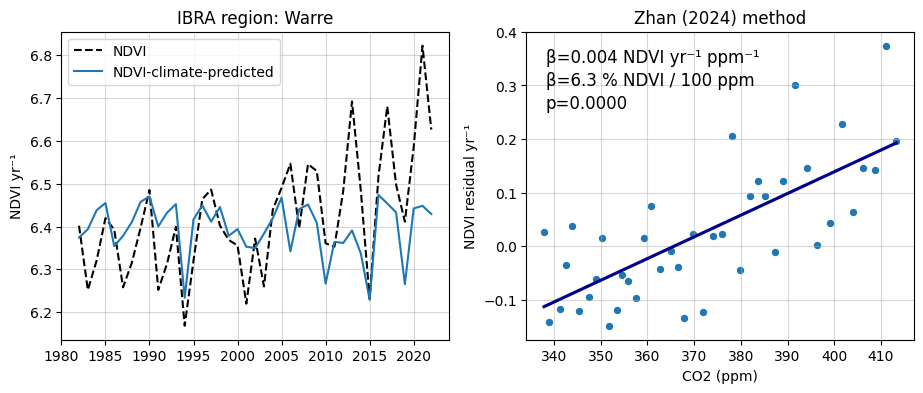

In [16]:
#find robust regression slope
beta  = theilslopes(y=df['NDVI_residual'], x=df['co2']).slope
beta_relative = theilslopes(y=df['NDVI_residual_percent'], x=df['co2']).slope * 100 * 100

pvalue = kendalltau(y=df['NDVI_residual'], x=df['co2']).pvalue

# beta  = linregress(y=df['NDVI_residual'], x=df['co2']).slope
# beta_relative = linregress(y=df['NDVI_residual_percent'], x=df['co2']).slope * 100 * 100

fig,ax = plt.subplots(1,2, figsize=(11,4))
df['NDVI'].plot(ax=ax[0], label='NDVI', linestyle='dashed', color='k')
df['NDVI_predict'].plot(ax=ax[0], label='NDVI-climate-predicted')
ax[0].set_ylabel('NDVI yr⁻¹')
ax[0].set_title('IBRA region: '+k)
ax[0].grid(alpha=0.5)
ax[0].set_xlabel(None)
ax[0].legend()

sb.scatterplot(data=df, x='co2',y='NDVI_residual', s=40, lw=1,ax=ax[1])
sb.regplot(data=df, x='co2',y='NDVI_residual', scatter=False, color='darkblue', ax=ax[1], ci=None, robust=False)
ax[1].set_ylabel('NDVI residual yr⁻¹')
ax[1].set_xlabel('CO2 (ppm)')
ax[1].set_title('Zhan (2024) method')
# ax[1].set_ylim(-2,2)
ax[1].grid(alpha=0.5)
ax[1].text(.05, .90, '\u03B2={:.3f} NDVI yr⁻¹ ppm⁻¹'.format(beta),
            transform=ax[1].transAxes, fontsize=12);
ax[1].text(.05, .825, '\u03B2={:.1f} % NDVI / 100 ppm'.format(beta_relative) ,
            transform=ax[1].transAxes, fontsize=12);
ax[1].text(.05, .75, 'p={:.4f}'.format(pvalue),
            transform=ax[1].transAxes, fontsize=12);

## Test experiments holding CO2 constant

Residual between prediction when all variables kept original, and where CO2 is kept constant.

1. Model iNDVI using CO2, SRAD, VPD, rain, Tavg
2. Model iNDVI with CO2 set at average of first 3 years.
3. Find residual between iNDVI-predicted and iNDVI-CO2-constant
4. Plot residual iNDVI against CO2 and determine beta

### Modelling

In [17]:
# fit a model on observed data
x = df[['rain', 'srad', 'tavg', 'vpd', 'co2', 'cwd']] # original data
y = df['NDVI']

lr = PLSRegression(n_components=2).fit(x, y)
prediction = lr.predict(x)

# now fit a model with CO2 held constant
constant_co2 = x['co2'].iloc[0:3].mean() #average of first 3 years
xx = x.drop('co2', axis=1)
xx['co2'] = constant_co2

lrr = PLSRegression(n_components=2).fit(xx, y)
pred_co2_constant = lrr.predict(xx)

# determine residual between predicted with and without co2 held constant
df['NDVI_residual_co2constant'] =  df['NDVI'] - pred_co2_constant
df['NDVI_residual_co2constant_percent'] = df['NDVI_residual_co2constant']/df['NDVI'] # np.mean(prediction[0:5])

### Plot

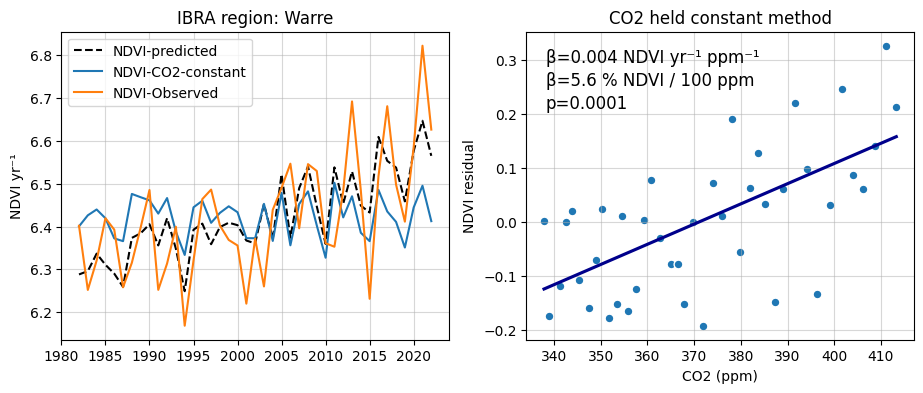

In [18]:
#find robust regression slope
regress  = theilslopes(y=df['NDVI_residual_co2constant'], x=df['co2'])
beta = regress.slope 
beta_relative = theilslopes(y=df['NDVI_residual_co2constant_percent'], x=df['co2']).slope * 100 * 100
pvalue = kendalltau(y=df['NDVI_residual_co2constant'], x=df['co2']).pvalue

fig,ax = plt.subplots(1,2, figsize=(11,4))
ax[0].plot(df.index, prediction, label='NDVI-predicted', linestyle='dashed', color='k')
ax[0].plot(df.index, pred_co2_constant, label='NDVI-CO2-constant')
ax[0].plot(df.index, df['NDVI'].values, label='NDVI-Observed')

ax[0].set_ylabel('NDVI yr⁻¹')
ax[0].set_title('IBRA region: '+k)
ax[0].grid(alpha=0.5)
ax[0].set_xlabel(None)
ax[0].legend()

sb.scatterplot(data=df, x='co2',y='NDVI_residual_co2constant', s=40, lw=1,ax=ax[1])
sb.regplot(data=df, x='co2',y='NDVI_residual_co2constant', scatter=False, color='darkblue', ax=ax[1], ci=None, robust=True)
ax[1].set_ylabel('NDVI residual')
ax[1].set_xlabel('CO2 (ppm)')
# ax[1].set_ylim(-300,300)
ax[1].set_title('CO2 held constant method')
ax[1].grid(alpha=0.5)
ax[1].text(.05, .90, '\u03B2={:.3f} NDVI yr⁻¹ ppm⁻¹'.format(beta),
            transform=ax[1].transAxes, fontsize=12);
ax[1].text(.05, .825, '\u03B2={:.1f} % NDVI / 100 ppm'.format(beta_relative) ,
            transform=ax[1].transAxes, fontsize=12);
ax[1].text(.05, .75, 'p={:.4f}'.format(pvalue),
            transform=ax[1].transAxes, fontsize=12);

## Test func 

In [ ]:
# %load_ext autoreload
# %autoreload 2

# import sys
# sys.path.append('/g/data/os22/chad_tmp/Aus_CO2_fertilisation/src')
# from analysis import _preprocess, regression_attribution, robust_trends, calculate_beta

In [ ]:
# d, dd, ss, Y, idx_all_nan, nan_mask, shape = _preprocess(ds, covariables, ndvi_min)

In [ ]:
# i=400000
# # i=0
# results=[]
# for i in range(shape[1])[0:10]:
#     data = Y.isel(spatial=i)
    
#     if i in idx_all_nan:
#         xx = xr.DataArray(name='slope', data=np.nan,
#                           coords={'longitude':[1], 'latitude':[1]},
#                           dims=['latitude', 'longitude']).to_dataset()
#         xx['p_value'] = xx['slope']
#         # xx = trend_template.copy() #use our template    
#         xx['latitude'] = [data.latitude.values.item()] #update coords
#         xx['longitude'] = [data.longitude.values.item()]
    
#     else:
#         #run the trend function
#         xx = robust_trends(data)
    
#     results.append(xx.compute())

# trends = xr.combine_by_coords(results).astype('float32')

In [ ]:
# modelling_vars=['co2', 'srad', 'rain', 'tavg', 'vpd', 'cwd']
# for model_type in ['PLS']:
#     regress_template = xr.open_dataset(f'/g/data/os22/chad_tmp/Aus_CO2_fertilisation/data/templates/template_{model_type}.nc').sel(feature=modelling_vars)
    
#     p_attribution = []    
#     for i in range(shape[1])[400000:400001]: #loop through all spatial indexes.
#         #select pixel
#         data = Y.isel(spatial=i)
        
#         lat = data.latitude.item()
#         lon = data.longitude.item()
        
#         fi = regression_attribution(data,
#                            X=dd.sel(latitude=lat, longitude=lon),
#                            template=regress_template,
#                            model_type=model_type,
#                            modelling_vars=modelling_vars,
#                           )
#         p_attribution.append(fi.compute())
    
#     p_attribution = xr.combine_by_coords(p_attribution).astype('float32')

In [ ]:
# modelling_vars=['co2', 'srad', 'rain', 'tavg', 'vpd']
    
# beta = []    
# for i in range(shape[1])[0:10]: #loop through all spatial indexes.
#     #select pixel
#     data = Y.isel(spatial=i)
    
#     lat = data.latitude.item()
#     lon = data.longitude.item()
    
#     fi = calculate_beta(data,
#                        X=dd.sel(latitude=lat, longitude=lon),
#                        model_var='NDVI',
#                        modelling_vars=modelling_vars,
#                       )
#     beta.append(fi.compute())

# beta = xr.combine_by_coords(beta).astype('float32')